In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import random
import sys
sys.path.append('..')
sys.path.append('../src')

from src.generative import Memorizer
from src.utils import set_plotting_params

In [42]:
colors = sns.color_palette('colorblind')

# Set random seed for reproducibility
# random.seed(42)
# torch.manual_seed(42)

# Define transformations for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='../data.nosync/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data.nosync/', train=False, download=True, transform=transform)

# Filter for class 8 samples
train_samples_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == 8]
test_samples_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == 8]

# Function to add a colored border to images
def add_border(img, color, border_size=5):
    # Convert to PIL Image in grayscale
    img = img.squeeze(0)  # Remove the channel dimension (1,)
    img = Image.fromarray((img.numpy() * 255).astype(np.uint8), mode='L')  # Grayscale

    # Add colored border
    img_with_border = ImageOps.expand(img.convert("RGB"), border=border_size, fill=color)  # Convert to RGB after expanding
    return img_with_border

# Select 10 random samples from training and test sets for class 8
num_samples = 30
train_samples_idx = random.sample(train_samples_indices, num_samples)
test_samples_idx = random.sample(test_samples_indices, num_samples)

# Prepare train and test samples with colored borders
set1_images = [add_border(train_dataset[i][0], 'blue', border_size=5) for i in train_samples_idx]
set2_images = [add_border(test_dataset[i][0], 'orange', border_size=5) for i in test_samples_idx]

# Generate random positions for the images
def generate_random_positions(num_images, canvas_size):
    positions = []
    img_width, img_height = 28 + 10, 28 + 10  # MNIST image size (28x28) + border size
    for _ in range(num_images):
        x = random.randint(0, canvas_size[0] - img_width)
        y = random.randint(0, canvas_size[1] - img_height)
        positions.append((x, y))
    return positions

# Set canvas size
canvas_size = (500, 300)

# Get random positions for both sets
positions_set1 = generate_random_positions(len(set1_images), canvas_size)
positions_set2 = generate_random_positions(len(set2_images), canvas_size)

# Create a blank canvas
canvas = Image.new('RGB', canvas_size, (255, 255, 255))  # 'RGB' mode for colored borders

# Paste Set 1 images (training set) at random positions
for img, pos in zip(set1_images, positions_set1):
    canvas.paste(img, pos)

# Paste Set 2 images (test set) at random positions
for img, pos in zip(set2_images, positions_set2):
    canvas.paste(img, pos)

# Convert the canvas to an array for displaying
canvas_array = np.array(canvas)

# Plot the final result
plt.figure(figsize=(10, 7))
plt.imshow(canvas_array)
plt.axis('off')
plt.savefig('../doc/Flowchart/vis_high_dim.png')
plt.close()


In [43]:
num_plots = 3
fig_size_inch = 120 / 72

for i in range(num_plots):
    # visualize data-copying with p being uniform 
    X = np.random.rand(20, 2)

    q = Memorizer(n_copying=3, radius=0.075)
    X_gen = q.fit(X).sample(8)
    X3 = np.random.rand(10, 2)

    # stack X_gen and X3
    X_gen = np.vstack([X_gen, X3])
    plt.figure(figsize=(fig_size_inch, fig_size_inch))
    plt.scatter(X[:, 0], X[:, 1], color=colors[0], marker='o')
    plt.scatter(X_gen[:, 0], X_gen[:, 1], color=colors[1], marker='x')
    # plot circles around q.subset
    for j in range(q.n_copying):
        circle = plt.Circle(q.subset[j], 0.085, color='black', fill=False, linewidth=1)
        plt.gca().add_artist(circle)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=0.1)
    plt.savefig(f'../doc/Flowchart/vis_low_dim{i}.png')
    plt.close()



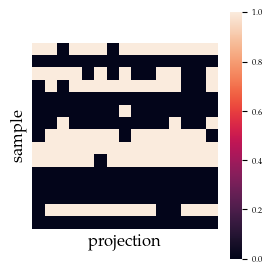

In [58]:
textwidth = set_plotting_params()

# create a heatmap with data copying
n = 15

# for each row assign probability that this is a data copying
p = np.random.rand(n)
# if a value is between 0.25 and 0.75, assign 0
p[(p > 0.3) & (p < 0.7)] = 0

# row each entry in each row draw from a bernoulli distribution with p
X = np.random.binomial(1, p, (n, n))

plt.figure(figsize=(0.5*textwidth, 0.5*textwidth))
sns.heatmap(X.T, square=True)
plt.xlabel('projection', fontsize=12)
plt.ylabel('sample', fontsize=12)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

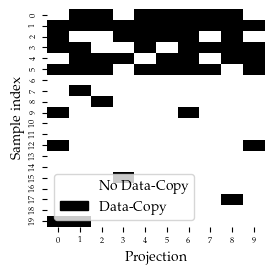

In [71]:
# Adjust the size of the heatmap to 20 rows and 10 columns
rows, cols = 20, 10
data_size = rows * cols

# Recreate the heatmap data with the same probabilities
heatmap_data = np.zeros(data_size)

# Set first 30% of the data with 70% chance for 1
first_chunk_size = int(0.3 * data_size)
heatmap_data[:first_chunk_size] = np.random.choice([0, 1], size=first_chunk_size, p=[1 - high_prob, high_prob])

# Set remaining 70% of the data with 10% chance for 1
remaining_chunk_size = data_size - first_chunk_size
heatmap_data[first_chunk_size:] = np.random.choice([0, 1], size=remaining_chunk_size, p=[1 - low_prob, low_prob])

# Reshape to 20x10 for heatmap plotting
heatmap_data = heatmap_data.reshape((rows, cols))

# Plotting the heatmap with black and white color scheme
plt.figure(figsize=(0.5*textwidth, 0.5*textwidth))
ax = sns.heatmap(heatmap_data, cmap=ListedColormap(['white', 'black']), cbar=False)

# Create custom patches for the legend (0 and 1 with their respective colors)
zero_patch = mpatches.Patch(color='white', label='No Data-Copy')
one_patch = mpatches.Patch(color='black', label='Data-Copy')

# Add the custom legend to the plot
plt.legend(handles=[zero_patch, one_patch], loc='lower left', fontsize=10)

# Set axis labels and title
ax.set_xlabel('Projection', fontsize=10)
ax.set_ylabel('Sample index', fontsize=10)
# ax.set_xticks([])
# ax.set_yticks([])
plt.tight_layout()

# Display the plot
plt.show()